In [2]:
pip install sentencepiece

     ------------------------------------- 991.5/991.5 kB 10.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
import sentencepiece

In [4]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import (
    DebertaV2Tokenizer, DebertaV2ForSequenceClassification,
    TrainingArguments, Trainer, DataCollatorWithPadding,
    TrainerCallback, EarlyStoppingCallback
)
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt


C:\ProgramData\anaconda3\lib\site-packages\transformers\utils\generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
C:\ProgramData\anaconda3\lib\site-packages\transformers\utils\generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
C:\ProgramData\anaconda3\lib\site-packages\transformers\utils\generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


In [5]:
# 📂 Load and preprocess dataset
df = pd.read_csv("./dataset.csv")
df.columns = df.columns.str.strip()
df = df.iloc[1:]
df = df[df['Level'].isin([0, 1, 2, 3])]
df['Level'] = df['Level'].astype(int)
df.rename(columns={'Level': 'labels'}, inplace=True)

In [6]:
# 🧪 Train-test split
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['labels'], random_state=42)

# 📤 Convert to HuggingFace Datasets
train_ds = Dataset.from_pandas(train_df)
test_ds = Dataset.from_pandas(test_df)

# 🔠 Tokenization
tokenizer = DebertaV2Tokenizer.from_pretrained("microsoft/deberta-v3-base")

def tokenize_function(example):
    return tokenizer(example["Response"], truncation=True)

train_ds = train_ds.map(tokenize_function, batched=True)
test_ds = test_ds.map(tokenize_function, batched=True)

C:\ProgramData\anaconda3\lib\site-packages\huggingface_hub\file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

Map:   0%|          | 0/4112 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/1029 [00:00<?, ? examples/s]

In [7]:
# 📦 Data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# 🧠 Load DeBERTa model
model = DebertaV2ForSequenceClassification.from_pretrained(
    "microsoft/deberta-v3-base", num_labels=4
)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

C:\ProgramData\anaconda3\lib\site-packages\transformers\modeling_utils.py:519: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file, map_location=

In [8]:
# 📊 Metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = torch.argmax(torch.tensor(logits), axis=-1).numpy()
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        "accuracy": acc,
        "macro_precision": precision,
        "macro_recall": recall,
        "macro_f1": f1,
    }


In [9]:
# 🧩 Accuracy tracker callback
class AccuracyTrackerCallback(TrainerCallback):
    def __init__(self, trainer_ref):
        self.trainer = trainer_ref
        self.train_accuracies = []
        self.eval_accuracies = []

    def on_epoch_end(self, args, state, control, **kwargs):
        train_output = self.trainer.predict(self.trainer.train_dataset)
        train_preds = train_output.predictions.argmax(axis=1)
        train_labels = train_output.label_ids
        train_acc = accuracy_score(train_labels, train_preds)
        self.train_accuracies.append(train_acc)

        eval_output = self.trainer.predict(self.trainer.eval_dataset)
        eval_preds = eval_output.predictions.argmax(axis=1)
        eval_labels = eval_output.label_ids
        eval_acc = accuracy_score(eval_labels, eval_preds)
        self.eval_accuracies.append(eval_acc)

        print(f"\n📊 Epoch {state.epoch:.0f} → Train Acc: {train_acc:.4f} | Val Acc: {eval_acc:.4f}")

In [10]:
# ⚙️ Training arguments
training_args = TrainingArguments(
    output_dir="./deberta_results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    logging_dir="./deberta_logs",
    logging_steps=50,
    save_total_limit=2
)


In [11]:
# 🏋️ Trainer setup
accuracy_logger = AccuracyTrackerCallback(None)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[
        accuracy_logger,
        EarlyStoppingCallback(early_stopping_patience=2)
    ]
)

accuracy_logger.trainer = trainer

In [12]:
# 🚀 Train model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Macro Precision,Macro Recall,Macro F1
1,0.441000,0.222495,0.936832,0.935750,0.923985,0.928267
2,0.147100,0.286559,0.940719,0.935994,0.936602,0.935699
3,0.082600,0.232125,0.956268,0.952794,0.951506,0.952087
4,0.019200,0.260154,0.963071,0.961980,0.957725,0.959736
5,0.021400,0.240289,0.965986,0.964393,0.960462,0.962249
6,0.009000,0.255680,0.965015,0.963545,0.960184,0.961788
7,0.006000,0.298799,0.963071,0.965318,0.955799,0.959935



📊 Epoch 1 → Train Acc: 0.9540 | Val Acc: 0.9368

📊 Epoch 2 → Train Acc: 0.9820 | Val Acc: 0.9407

📊 Epoch 3 → Train Acc: 0.9959 | Val Acc: 0.9563

📊 Epoch 4 → Train Acc: 0.9976 | Val Acc: 0.9631

📊 Epoch 5 → Train Acc: 0.9981 | Val Acc: 0.9660

📊 Epoch 6 → Train Acc: 0.9993 | Val Acc: 0.9650

📊 Epoch 7 → Train Acc: 0.9998 | Val Acc: 0.9631


TrainOutput(global_step=3598, training_loss=0.1405162417056508, metrics={'train_runtime': 16401.9858, 'train_samples_per_second': 2.507, 'train_steps_per_second': 0.313, 'total_flos': 360610754709696.0, 'train_loss': 0.1405162417056508, 'epoch': 7.0})

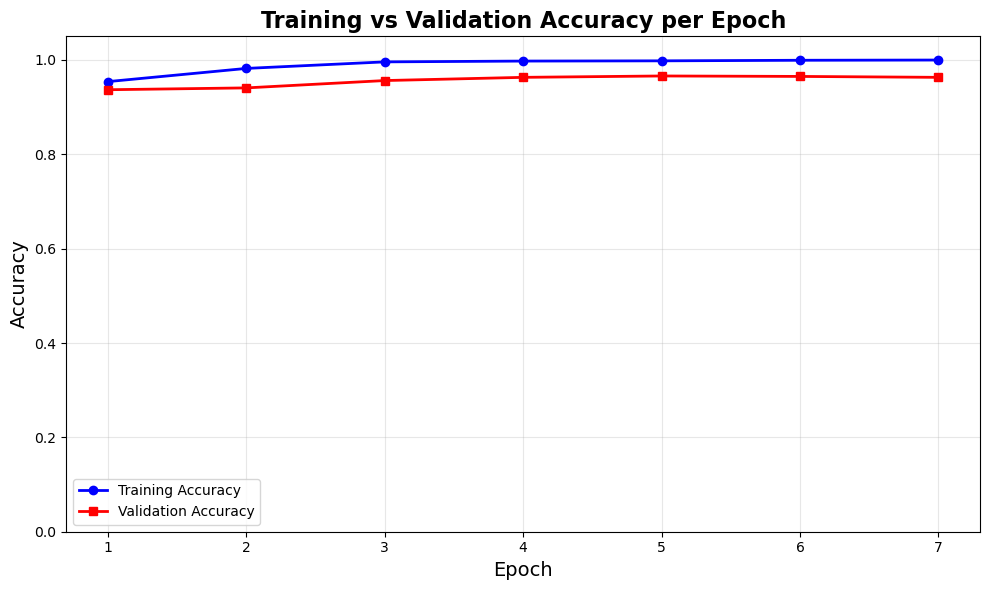

In [13]:

# 📈 Plot Training vs Validation Accuracy
train_accs = accuracy_logger.train_accuracies
val_accs = accuracy_logger.eval_accuracies
epochs = range(1, len(train_accs) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accs, label="Training Accuracy", marker='o', linewidth=2, color='blue')
plt.plot(epochs, val_accs, label="Validation Accuracy", marker='s', linewidth=2, color='red')

plt.title("Training vs Validation Accuracy per Epoch", fontsize=16, fontweight='bold')
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.ylim(0, 1.05)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


🔍 Classification Report:

              precision    recall  f1-score   support

     Level 0     0.9686    0.9912    0.9798       342
     Level 1     0.9749    0.9282    0.9510       209
     Level 2     0.9388    0.9436    0.9412       195
     Level 3     0.9754    0.9788    0.9771       283

    accuracy                         0.9660      1029
   macro avg     0.9644    0.9605    0.9622      1029
weighted avg     0.9661    0.9660    0.9659      1029


📊 Final Test Accuracy: 0.9660


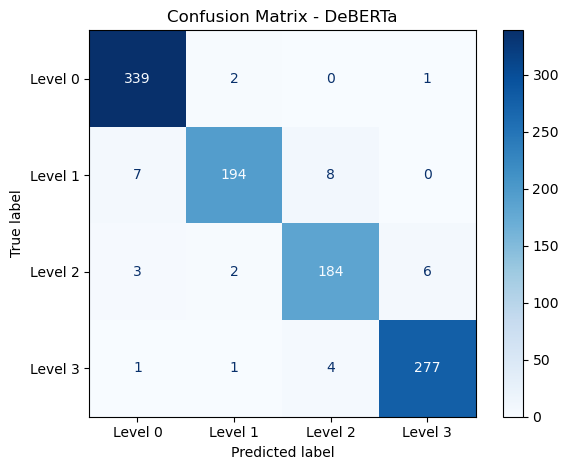

In [14]:
# 📊 Final evaluation
preds = trainer.predict(test_ds)
y_pred = preds.predictions.argmax(axis=1)
y_true = preds.label_ids

print("\n🔍 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=["Level 0", "Level 1", "Level 2", "Level 3"], digits=4))
print(f"\n📊 Final Test Accuracy: {accuracy_score(y_true, y_pred):.4f}")

# 📉 Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Level 0", "Level 1", "Level 2", "Level 3"])
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix - DeBERTa")
plt.tight_layout()
plt.show()